Copyright 2021 Takehiro Ajioka

### Enviroment

Python 3.6
Anaconda
tensorflow-gpu==1.15.0
keras==2.3.1
shap==0.36.0
tfdeterminism==0.3.0

In [1]:
# Ignore warning
import os
import tensorflow as tf
import logging
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)

In [2]:
import numpy
import pandas
import matplotlib.pyplot as plt
from scipy import io
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, ConvLSTM2D, Bidirectional
from sklearn.metrics import roc_curve
from sklearn.metrics import auc, roc_auc_score

In [3]:
# Allow grouth option of GPU
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [4]:
# Load data
signal = io.loadmat('../data/signal_5mice.mat')
runrest = io.loadmat('../data/runrest_5mice.mat')

In [5]:
plt.rcParams["font.size"] = 18

# Preprocess

In [6]:
# Mini-max normalization
def mini_max(dataset):
    min_value = dataset.min(axis=0)
    max_value = dataset.max(axis=0)
    dataset_nor = (dataset - min_value) / (max_value - min_value)
    return dataset_nor

In [7]:
# Create input data [-n,n+1]
def create_dataset(dataset, look_frame):
    dataX, dataY = [], []
    for i in range(look_frame,len(dataset)-(look_frame)):
        xset = []
        for j in range(dataset.shape[1]-1):
            a = dataset[(i-look_frame):(i+look_frame+1), j]
            xset.append(a)
        dataY.append(dataset[i, -1])      
        dataX.append(xset)
    return numpy.array(dataX), numpy.array(dataY)

In [8]:
look_frame = 15 #read the previous and next n frames as input

def Data_preprocess(signal, runrest, region):
    # Normalize
    signal = mini_max(signal.transpose())
    runrest = runrest.transpose()
    # Delete signals of unselected region
    signal[:,list(set(range(50))-region)] = 0
    # Create dataset
    dataset = numpy.hstack([signal.astype('float32'), runrest.astype('float32')])
    X, Y = create_dataset(dataset, look_frame)
    return X, Y

In [9]:
def Get_Dataset(TEST, REGION):
    print('TEST')
    # Test dataset
    testX = numpy.empty([0,50,31], dtype=numpy.float32)
    testY = numpy.empty(0, dtype=numpy.float32)
    for i in TEST:
        print(f'Mouse {i}')
        for j in range(signal['signal'+str(i)].shape[1]):
            X, Y = Data_preprocess(signal['signal'+str(i)][0,j], runrest['runrest'+str(i)][0,j], REGION)
            testX = numpy.concatenate([testX, X], axis=0)
            testY = numpy.concatenate([testY, Y], axis=0)

    return testX, testY

# Evaluate

In [10]:
# region number to index
def region_index(region_num):
    region_index = []
    for re in region_num:
        region_index.append(re - 1)
    return set(region_index)

In [11]:
# Select 4 regions
selected_region = [6,8,31,33]

In [12]:
# Region number
MOTER = [1,2,3,4,26,27,28,29] # secondary and primary motor
SSL = [6,7,8,9,31,32,33,34] # somatosensory of frelimb and hindlimb
PR = [14,15,16,17,39,40,41,42] # parietal and retrosplenial
V1 = [18,19,20,21,43,44,45,46] # primary visual and medial visual
VA = [22,23,24,25,47,48,49,50] # lateral visual and supposed auditory
print(MOTER)
print(SSL)
print(PR)
print(V1)
print(VA)

[1, 2, 3, 4, 26, 27, 28, 29]
[6, 7, 8, 9, 31, 32, 33, 34]
[14, 15, 16, 17, 39, 40, 41, 42]
[18, 19, 20, 21, 43, 44, 45, 46]
[22, 23, 24, 25, 47, 48, 49, 50]


In [13]:
REGIONS = {'Motor':region_index(MOTER), 'SomatosensoryLimb':region_index(SSL), 'P-RS':region_index(PR),
           'V1-MV':region_index(V1), 'LV-SA':region_index(VA)}

In [14]:
import itertools

In [15]:
Models = ['GRU']

In [16]:
# Plot ROC curve
def plot_roc(y_pred, y_test, mode):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    AUC = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, label="AUC = {:.3f}".format(AUC))
    plt.title(mode + " ROC curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()
    print('AUC: {:.3f}'.format(AUC))
    opt_thr = thresholds[numpy.argmax(tpr - fpr)]
    print('Optimal threshold: {:.3f}'.format(opt_thr))
    return AUC

{0, 1, 2, 3, 25, 26, 27, 28}
TEST
Mouse 1


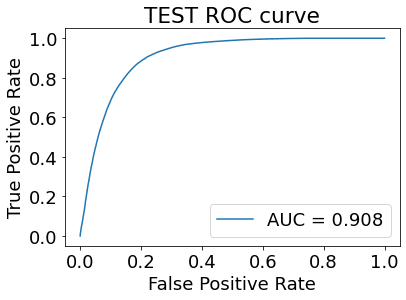

AUC: 0.908
Optimal threshold: 0.469
197670/197670 [==============================] - 42s 211us/sample - loss: 0.4122 - acc: 0.8290
{32, 33, 5, 6, 7, 8, 30, 31}
TEST
Mouse 1


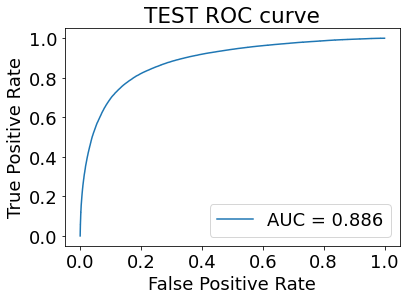

AUC: 0.886
Optimal threshold: 0.207
197670/197670 [==============================] - 42s 210us/sample - loss: 0.4393 - acc: 0.8114
{38, 39, 40, 41, 13, 14, 15, 16}
TEST
Mouse 1


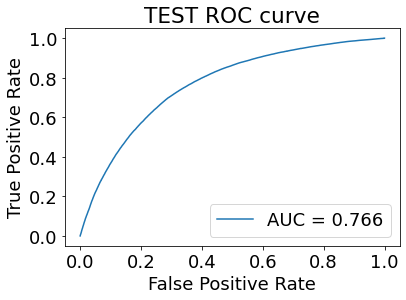

AUC: 0.766
Optimal threshold: 0.515
197670/197670 [==============================] - 42s 212us/sample - loss: 0.6322 - acc: 0.6957
{42, 43, 44, 45, 17, 18, 19, 20}
TEST
Mouse 1


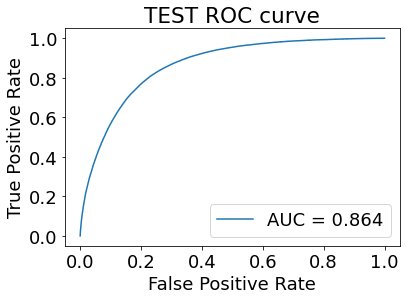

AUC: 0.864
Optimal threshold: 0.517
197670/197670 [==============================] - 41s 209us/sample - loss: 0.4791 - acc: 0.7782
{46, 47, 48, 49, 21, 22, 23, 24}
TEST
Mouse 1


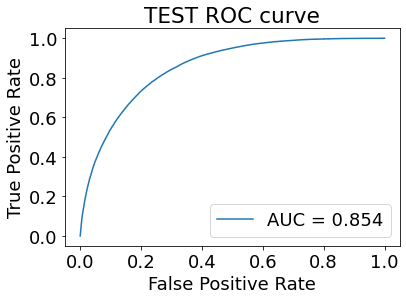

AUC: 0.854
Optimal threshold: 0.649
197670/197670 [==============================] - 42s 212us/sample - loss: 0.5763 - acc: 0.7255
{0, 1, 2, 3, 25, 26, 27, 28}
TEST
Mouse 1


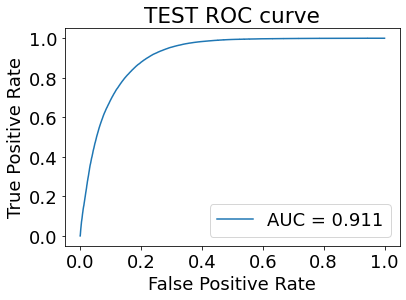

AUC: 0.911
Optimal threshold: 0.444
197670/197670 [==============================] - 41s 209us/sample - loss: 0.3769 - acc: 0.8304
{32, 33, 5, 6, 7, 8, 30, 31}
TEST
Mouse 1


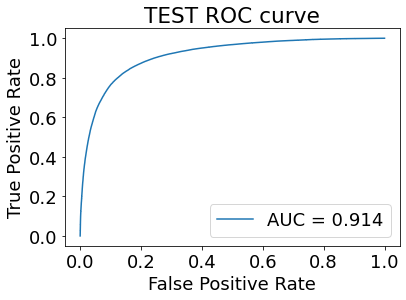

AUC: 0.914
Optimal threshold: 0.156
197670/197670 [==============================] - 42s 212us/sample - loss: 0.4182 - acc: 0.8230
{38, 39, 40, 41, 13, 14, 15, 16}
TEST
Mouse 1


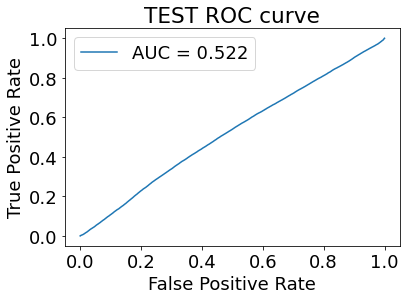

AUC: 0.522
Optimal threshold: 0.818
197670/197670 [==============================] - 42s 211us/sample - loss: 1.0577 - acc: 0.4102
{42, 43, 44, 45, 17, 18, 19, 20}
TEST
Mouse 1


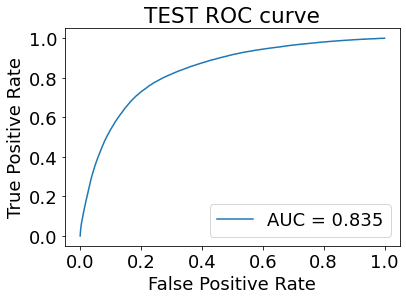

AUC: 0.835
Optimal threshold: 0.418
197670/197670 [==============================] - 42s 212us/sample - loss: 0.4943 - acc: 0.7773
{46, 47, 48, 49, 21, 22, 23, 24}
TEST
Mouse 1


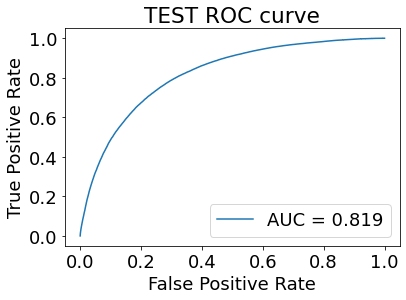

AUC: 0.819
Optimal threshold: 0.594
197670/197670 [==============================] - 43s 215us/sample - loss: 0.5810 - acc: 0.7093
{0, 1, 2, 3, 25, 26, 27, 28}
TEST
Mouse 1


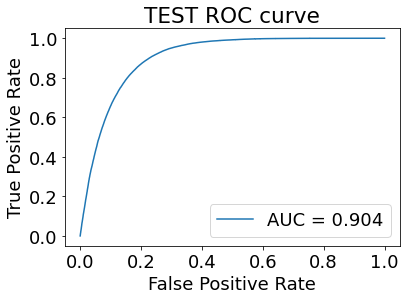

AUC: 0.904
Optimal threshold: 0.321
197670/197670 [==============================] - 42s 214us/sample - loss: 0.3766 - acc: 0.8285
{32, 33, 5, 6, 7, 8, 30, 31}
TEST
Mouse 1


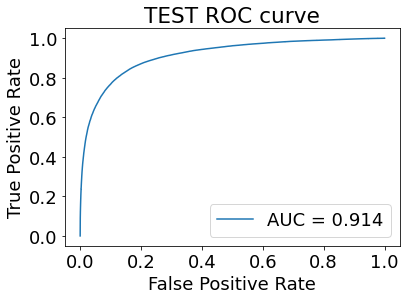

AUC: 0.914
Optimal threshold: 0.141
197670/197670 [==============================] - 42s 215us/sample - loss: 0.4278 - acc: 0.8234
{38, 39, 40, 41, 13, 14, 15, 16}
TEST
Mouse 1


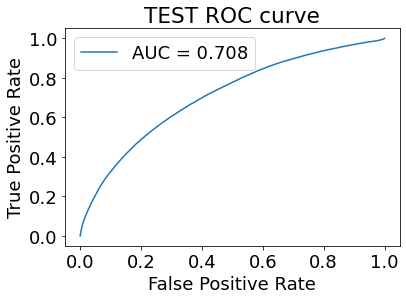

AUC: 0.708
Optimal threshold: 0.683
197670/197670 [==============================] - 42s 214us/sample - loss: 0.7663 - acc: 0.6001
{42, 43, 44, 45, 17, 18, 19, 20}
TEST
Mouse 1


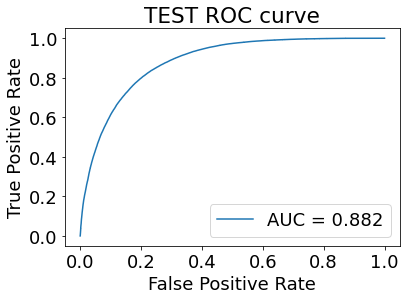

AUC: 0.882
Optimal threshold: 0.410
197670/197670 [==============================] - 43s 216us/sample - loss: 0.4219 - acc: 0.8022
{46, 47, 48, 49, 21, 22, 23, 24}
TEST
Mouse 1


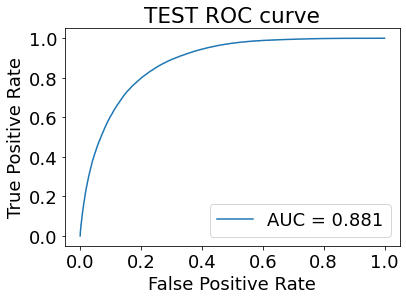

AUC: 0.881
Optimal threshold: 0.319
197670/197670 [==============================] - 43s 216us/sample - loss: 0.4365 - acc: 0.8036
{0, 1, 2, 3, 25, 26, 27, 28}
TEST
Mouse 1


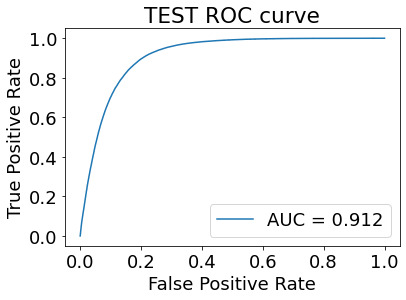

AUC: 0.912
Optimal threshold: 0.491
197670/197670 [==============================] - 44s 220us/sample - loss: 0.3829 - acc: 0.8359
{32, 33, 5, 6, 7, 8, 30, 31}
TEST
Mouse 1


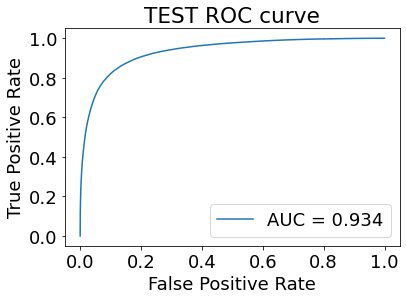

AUC: 0.934
Optimal threshold: 0.166
197670/197670 [==============================] - 44s 223us/sample - loss: 0.3606 - acc: 0.8488
{38, 39, 40, 41, 13, 14, 15, 16}
TEST
Mouse 1


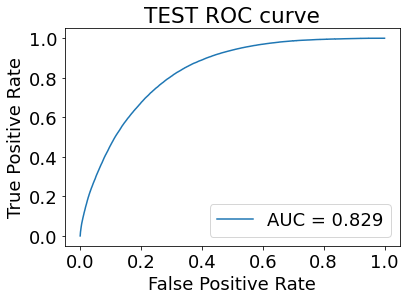

AUC: 0.829
Optimal threshold: 0.354
197670/197670 [==============================] - 45s 225us/sample - loss: 0.5429 - acc: 0.7508
{42, 43, 44, 45, 17, 18, 19, 20}
TEST
Mouse 1


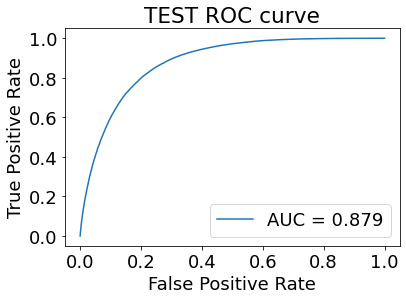

AUC: 0.879
Optimal threshold: 0.521
197670/197670 [==============================] - 45s 227us/sample - loss: 0.4616 - acc: 0.7876
{46, 47, 48, 49, 21, 22, 23, 24}
TEST
Mouse 1


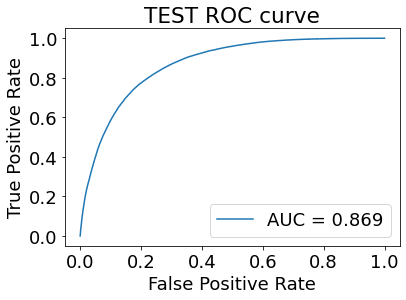

AUC: 0.869
Optimal threshold: 0.516
197670/197670 [==============================] - 45s 228us/sample - loss: 0.4672 - acc: 0.7797
{0, 1, 2, 3, 25, 26, 27, 28}
TEST
Mouse 2


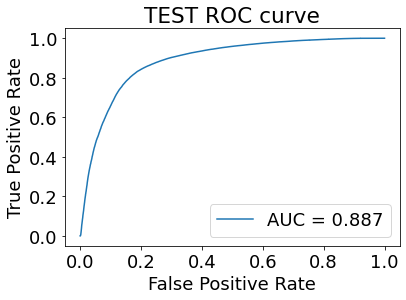

AUC: 0.887
Optimal threshold: 0.096
215640/215640 [==============================] - 49s 226us/sample - loss: 0.7598 - acc: 0.6893
{32, 33, 5, 6, 7, 8, 30, 31}
TEST
Mouse 2


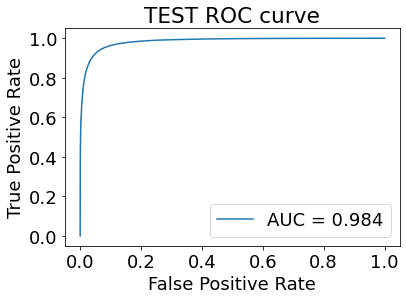

AUC: 0.984
Optimal threshold: 0.549
215640/215640 [==============================] - 49s 226us/sample - loss: 0.1580 - acc: 0.9408
{38, 39, 40, 41, 13, 14, 15, 16}
TEST
Mouse 2


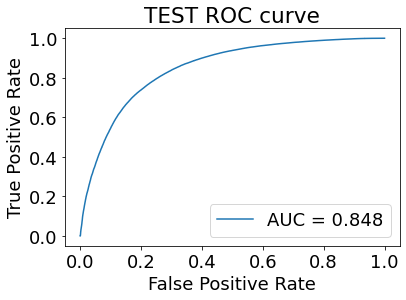

AUC: 0.848
Optimal threshold: 0.629
215640/215640 [==============================] - 49s 225us/sample - loss: 0.5151 - acc: 0.7929
{42, 43, 44, 45, 17, 18, 19, 20}
TEST
Mouse 2


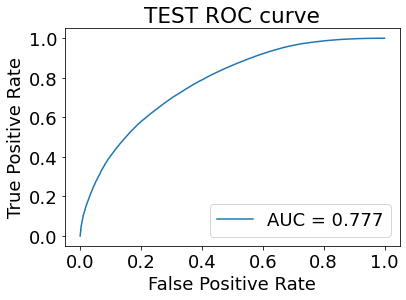

AUC: 0.777
Optimal threshold: 0.727
215640/215640 [==============================] - 49s 228us/sample - loss: 0.5656 - acc: 0.7367
{46, 47, 48, 49, 21, 22, 23, 24}
TEST
Mouse 2


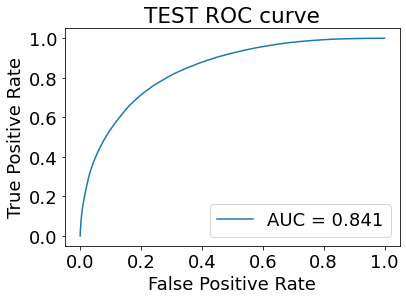

AUC: 0.841
Optimal threshold: 0.488
215640/215640 [==============================] - 49s 229us/sample - loss: 0.5154 - acc: 0.7562
{0, 1, 2, 3, 25, 26, 27, 28}
TEST
Mouse 2


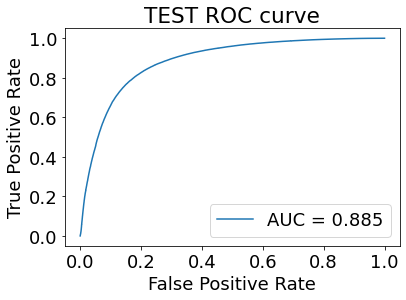

AUC: 0.885
Optimal threshold: 0.141
215640/215640 [==============================] - 49s 226us/sample - loss: 0.6969 - acc: 0.6958
{32, 33, 5, 6, 7, 8, 30, 31}
TEST
Mouse 2


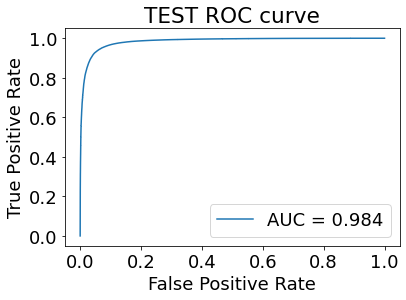

AUC: 0.984
Optimal threshold: 0.659
215640/215640 [==============================] - 48s 224us/sample - loss: 0.1519 - acc: 0.9446
{38, 39, 40, 41, 13, 14, 15, 16}
TEST
Mouse 2


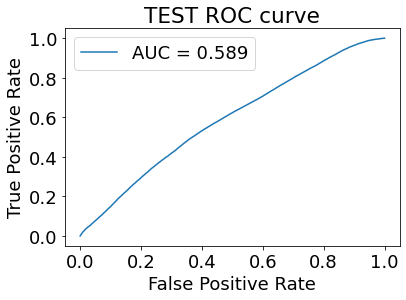

AUC: 0.589
Optimal threshold: 0.683
215640/215640 [==============================] - 48s 223us/sample - loss: 0.6994 - acc: 0.6105
{42, 43, 44, 45, 17, 18, 19, 20}
TEST
Mouse 2


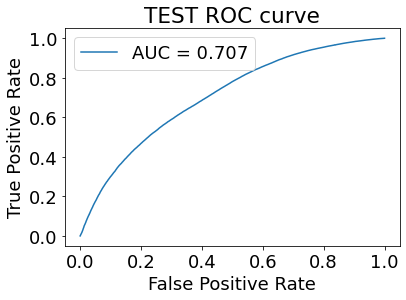

AUC: 0.707
Optimal threshold: 0.657
215640/215640 [==============================] - 48s 224us/sample - loss: 0.6737 - acc: 0.6754
{46, 47, 48, 49, 21, 22, 23, 24}
TEST
Mouse 2


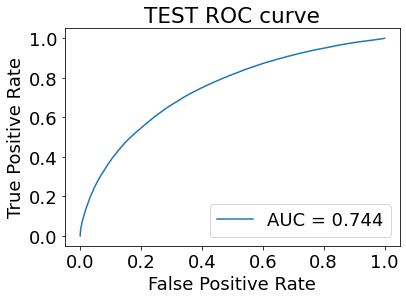

AUC: 0.744
Optimal threshold: 0.666
215640/215640 [==============================] - 49s 225us/sample - loss: 0.5688 - acc: 0.7104
{0, 1, 2, 3, 25, 26, 27, 28}
TEST
Mouse 2


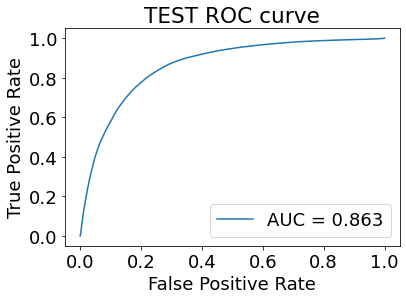

AUC: 0.863
Optimal threshold: 0.062
215640/215640 [==============================] - 50s 231us/sample - loss: 0.9523 - acc: 0.6723
{32, 33, 5, 6, 7, 8, 30, 31}
TEST
Mouse 2


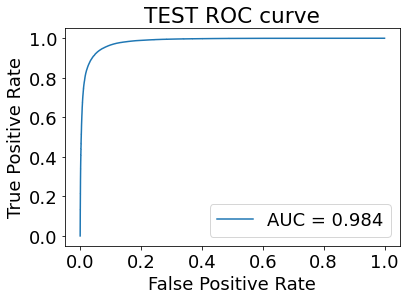

AUC: 0.984
Optimal threshold: 0.624
215640/215640 [==============================] - 50s 234us/sample - loss: 0.1514 - acc: 0.9428
{38, 39, 40, 41, 13, 14, 15, 16}
TEST
Mouse 2


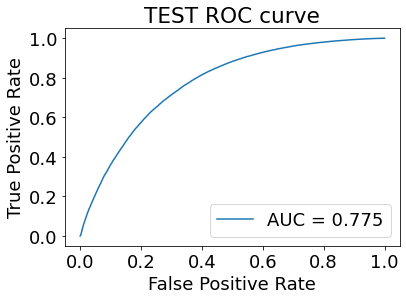

AUC: 0.775
Optimal threshold: 0.782
215640/215640 [==============================] - 50s 232us/sample - loss: 0.5635 - acc: 0.7463
{42, 43, 44, 45, 17, 18, 19, 20}
TEST
Mouse 2


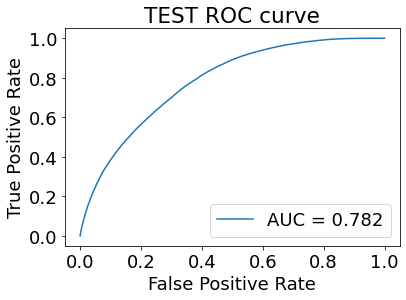

AUC: 0.782
Optimal threshold: 0.575
215640/215640 [==============================] - 50s 232us/sample - loss: 0.5653 - acc: 0.7498
{46, 47, 48, 49, 21, 22, 23, 24}
TEST
Mouse 2


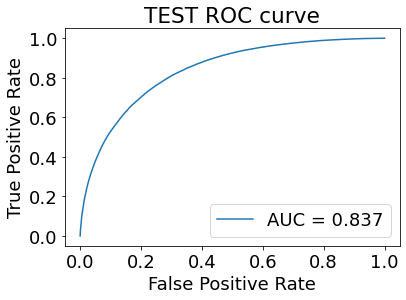

AUC: 0.837
Optimal threshold: 0.522
215640/215640 [==============================] - 50s 231us/sample - loss: 0.5261 - acc: 0.7619
{0, 1, 2, 3, 25, 26, 27, 28}
TEST
Mouse 2


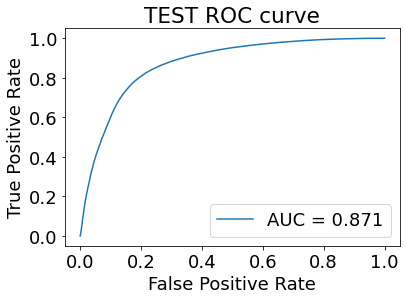

AUC: 0.871
Optimal threshold: 0.067
215640/215640 [==============================] - 49s 226us/sample - loss: 0.8655 - acc: 0.6654
{32, 33, 5, 6, 7, 8, 30, 31}
TEST
Mouse 2


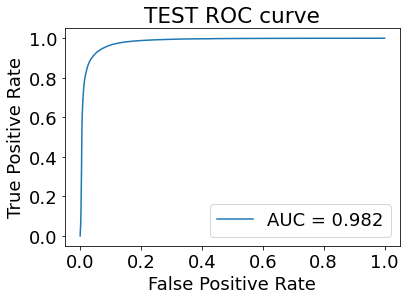

AUC: 0.982
Optimal threshold: 0.615
215640/215640 [==============================] - 49s 228us/sample - loss: 0.1538 - acc: 0.9430
{38, 39, 40, 41, 13, 14, 15, 16}
TEST
Mouse 2


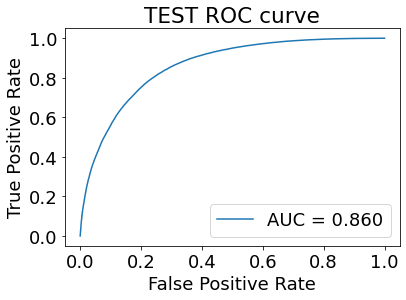

AUC: 0.860
Optimal threshold: 0.702
215640/215640 [==============================] - 50s 230us/sample - loss: 0.4495 - acc: 0.8087
{42, 43, 44, 45, 17, 18, 19, 20}
TEST
Mouse 2


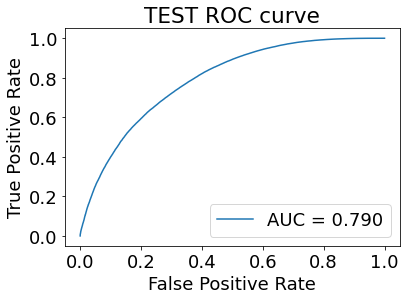

AUC: 0.790
Optimal threshold: 0.592
215640/215640 [==============================] - 51s 235us/sample - loss: 0.5795 - acc: 0.7473
{46, 47, 48, 49, 21, 22, 23, 24}
TEST
Mouse 2


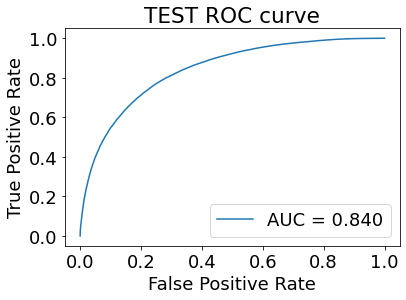

AUC: 0.840
Optimal threshold: 0.491
215640/215640 [==============================] - 51s 238us/sample - loss: 0.5403 - acc: 0.7623
{0, 1, 2, 3, 25, 26, 27, 28}
TEST
Mouse 3


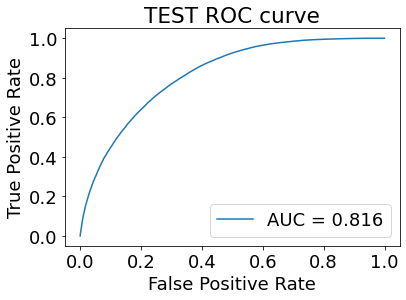

AUC: 0.816
Optimal threshold: 0.377
251580/251580 [==============================] - 59s 236us/sample - loss: 0.5725 - acc: 0.7295
{32, 33, 5, 6, 7, 8, 30, 31}
TEST
Mouse 3


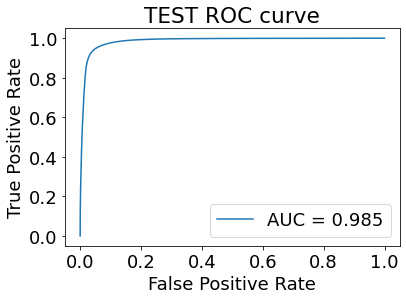

AUC: 0.985
Optimal threshold: 0.639
251580/251580 [==============================] - 59s 236us/sample - loss: 0.1379 - acc: 0.9513
{38, 39, 40, 41, 13, 14, 15, 16}
TEST
Mouse 3


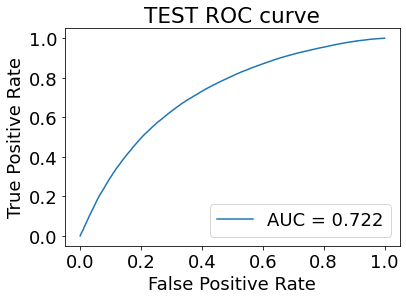

AUC: 0.722
Optimal threshold: 0.419
251580/251580 [==============================] - 59s 236us/sample - loss: 0.7893 - acc: 0.6555
{42, 43, 44, 45, 17, 18, 19, 20}
TEST
Mouse 3


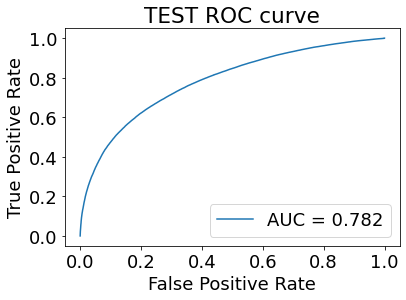

AUC: 0.782
Optimal threshold: 0.594
251580/251580 [==============================] - 59s 233us/sample - loss: 0.6191 - acc: 0.7109
{46, 47, 48, 49, 21, 22, 23, 24}
TEST
Mouse 3


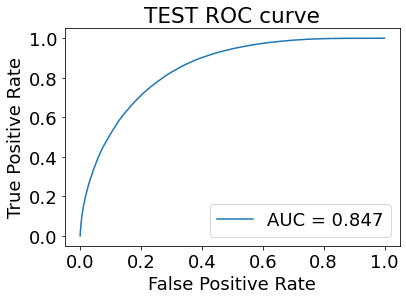

AUC: 0.847
Optimal threshold: 0.291
251580/251580 [==============================] - 59s 235us/sample - loss: 0.5825 - acc: 0.7295
{0, 1, 2, 3, 25, 26, 27, 28}
TEST
Mouse 3


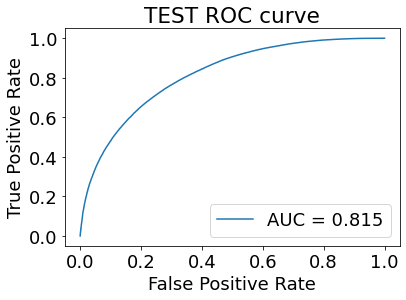

AUC: 0.815
Optimal threshold: 0.354
251580/251580 [==============================] - 59s 235us/sample - loss: 0.7005 - acc: 0.7121
{32, 33, 5, 6, 7, 8, 30, 31}
TEST
Mouse 3


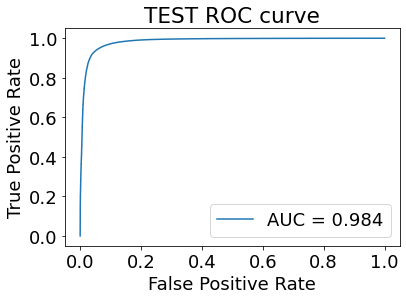

AUC: 0.984
Optimal threshold: 0.625
251580/251580 [==============================] - 58s 231us/sample - loss: 0.1472 - acc: 0.9470
{38, 39, 40, 41, 13, 14, 15, 16}
TEST
Mouse 3


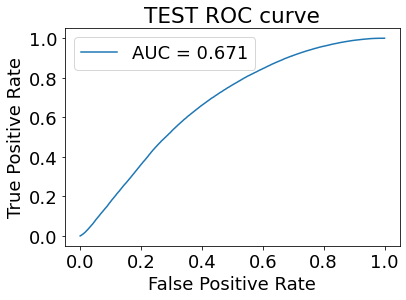

AUC: 0.671
Optimal threshold: 0.247
251580/251580 [==============================] - 58s 230us/sample - loss: 0.9336 - acc: 0.5996
{42, 43, 44, 45, 17, 18, 19, 20}
TEST
Mouse 3


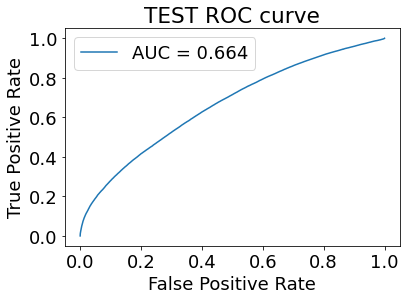

AUC: 0.664
Optimal threshold: 0.752
251580/251580 [==============================] - 58s 231us/sample - loss: 0.6456 - acc: 0.6620
{46, 47, 48, 49, 21, 22, 23, 24}
TEST
Mouse 3


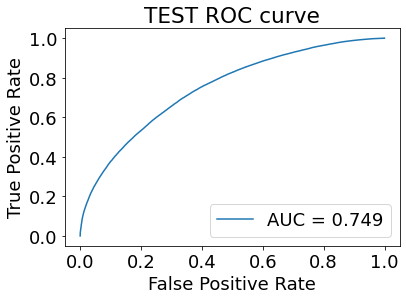

AUC: 0.749
Optimal threshold: 0.750
251580/251580 [==============================] - 59s 234us/sample - loss: 0.5937 - acc: 0.7133
{0, 1, 2, 3, 25, 26, 27, 28}
TEST
Mouse 3


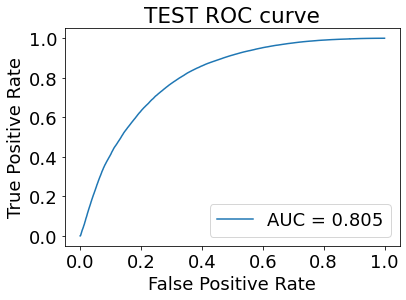

AUC: 0.805
Optimal threshold: 0.510
251580/251580 [==============================] - 59s 236us/sample - loss: 0.5642 - acc: 0.7562
{32, 33, 5, 6, 7, 8, 30, 31}
TEST
Mouse 3


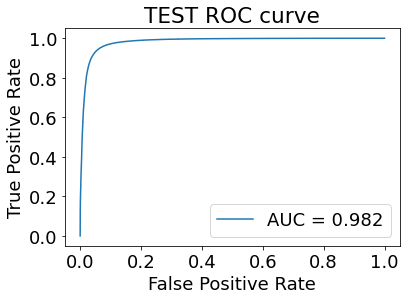

AUC: 0.982
Optimal threshold: 0.632
251580/251580 [==============================] - 59s 236us/sample - loss: 0.1524 - acc: 0.9474
{38, 39, 40, 41, 13, 14, 15, 16}
TEST
Mouse 3


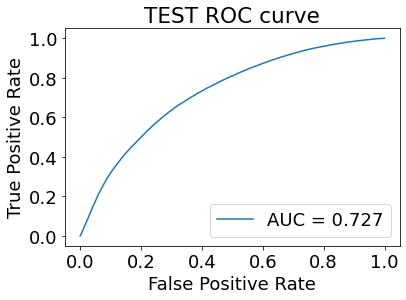

AUC: 0.727
Optimal threshold: 0.502
251580/251580 [==============================] - 59s 235us/sample - loss: 0.7192 - acc: 0.6681
{42, 43, 44, 45, 17, 18, 19, 20}
TEST
Mouse 3


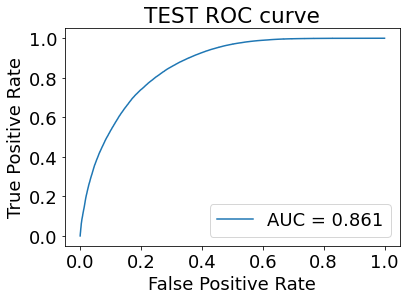

AUC: 0.861
Optimal threshold: 0.300
251580/251580 [==============================] - 59s 236us/sample - loss: 0.5369 - acc: 0.7506
{46, 47, 48, 49, 21, 22, 23, 24}
TEST
Mouse 3


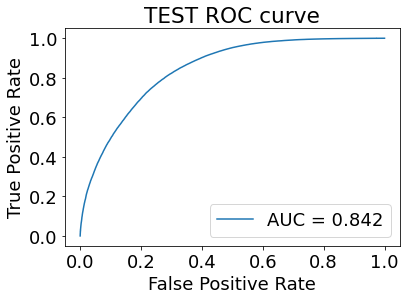

AUC: 0.842
Optimal threshold: 0.291
251580/251580 [==============================] - 61s 243us/sample - loss: 0.5878 - acc: 0.7261
{0, 1, 2, 3, 25, 26, 27, 28}
TEST
Mouse 3


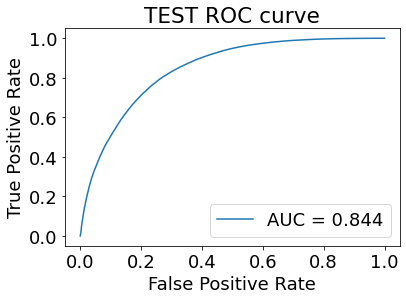

AUC: 0.844
Optimal threshold: 0.154
251580/251580 [==============================] - 61s 244us/sample - loss: 0.7926 - acc: 0.6753
{32, 33, 5, 6, 7, 8, 30, 31}
TEST
Mouse 3


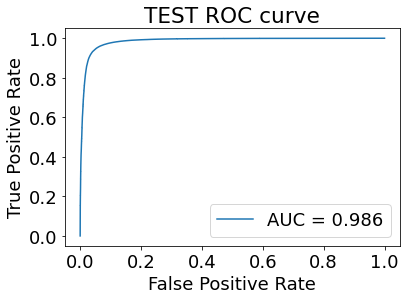

AUC: 0.986
Optimal threshold: 0.621
251580/251580 [==============================] - 62s 247us/sample - loss: 0.1386 - acc: 0.9514
{38, 39, 40, 41, 13, 14, 15, 16}
TEST
Mouse 3


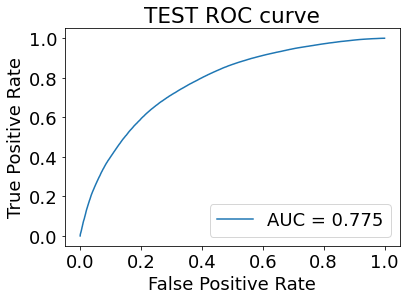

AUC: 0.775
Optimal threshold: 0.575
251580/251580 [==============================] - 60s 240us/sample - loss: 0.6021 - acc: 0.7203
{42, 43, 44, 45, 17, 18, 19, 20}
TEST
Mouse 3


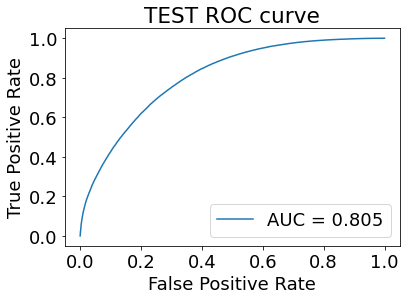

AUC: 0.805
Optimal threshold: 0.506
251580/251580 [==============================] - 60s 240us/sample - loss: 0.5409 - acc: 0.7456
{46, 47, 48, 49, 21, 22, 23, 24}
TEST
Mouse 3


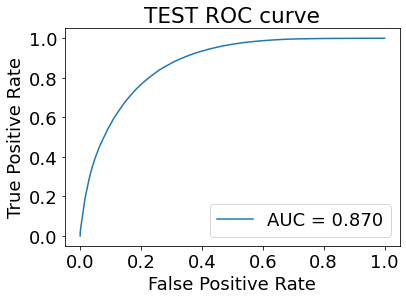

AUC: 0.870
Optimal threshold: 0.424
251580/251580 [==============================] - 60s 238us/sample - loss: 0.4653 - acc: 0.7876
{0, 1, 2, 3, 25, 26, 27, 28}
TEST
Mouse 4


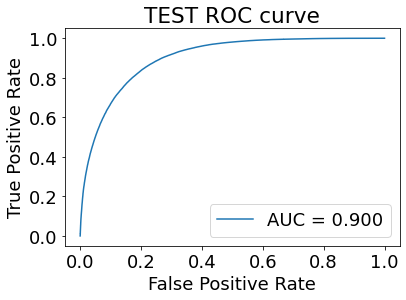

AUC: 0.900
Optimal threshold: 0.568
269550/269550 [==============================] - 66s 243us/sample - loss: 0.3929 - acc: 0.8286
{32, 33, 5, 6, 7, 8, 30, 31}
TEST
Mouse 4


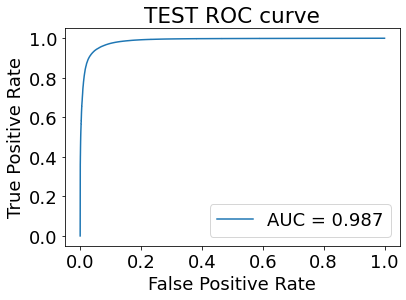

AUC: 0.987
Optimal threshold: 0.756
269550/269550 [==============================] - 67s 250us/sample - loss: 0.1492 - acc: 0.9435
{38, 39, 40, 41, 13, 14, 15, 16}
TEST
Mouse 4


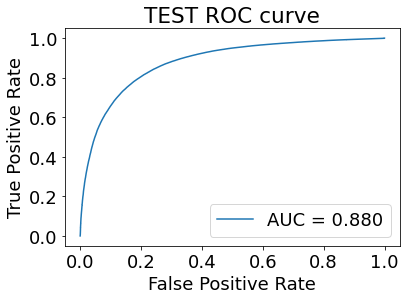

AUC: 0.880
Optimal threshold: 0.386
269550/269550 [==============================] - 70s 261us/sample - loss: 0.5099 - acc: 0.7942
{42, 43, 44, 45, 17, 18, 19, 20}
TEST
Mouse 4


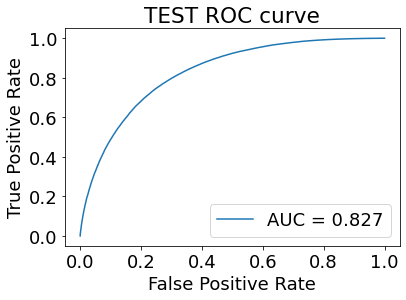

AUC: 0.827
Optimal threshold: 0.743
269550/269550 [==============================] - 71s 262us/sample - loss: 0.5382 - acc: 0.7483
{46, 47, 48, 49, 21, 22, 23, 24}
TEST
Mouse 4


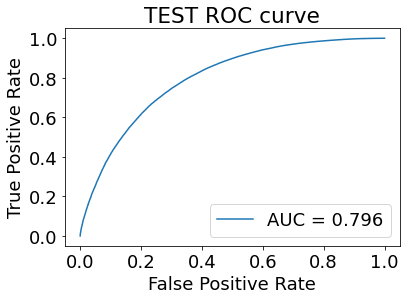

AUC: 0.796
Optimal threshold: 0.754
269550/269550 [==============================] - 71s 265us/sample - loss: 0.5992 - acc: 0.7320
{0, 1, 2, 3, 25, 26, 27, 28}
TEST
Mouse 4


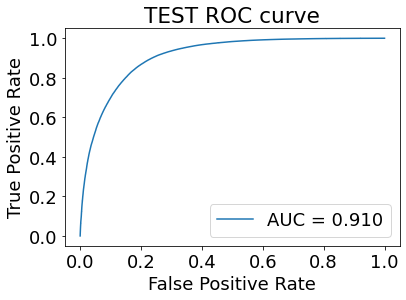

AUC: 0.910
Optimal threshold: 0.535
269550/269550 [==============================] - 71s 265us/sample - loss: 0.3765 - acc: 0.8414
{32, 33, 5, 6, 7, 8, 30, 31}
TEST
Mouse 4


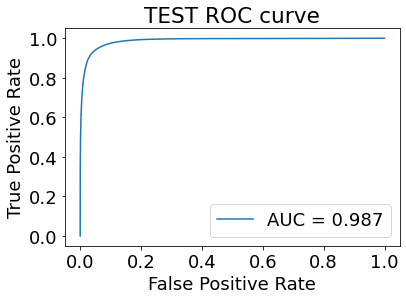

AUC: 0.987
Optimal threshold: 0.776
269550/269550 [==============================] - 70s 260us/sample - loss: 0.1480 - acc: 0.9440
{38, 39, 40, 41, 13, 14, 15, 16}
TEST
Mouse 4


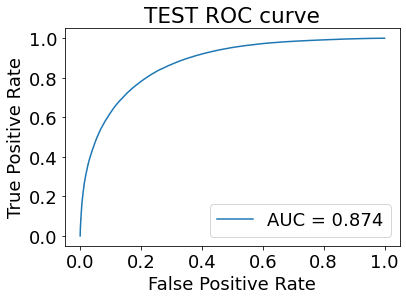

AUC: 0.874
Optimal threshold: 0.680
269550/269550 [==============================] - 73s 272us/sample - loss: 0.4575 - acc: 0.7962
{42, 43, 44, 45, 17, 18, 19, 20}
TEST
Mouse 4


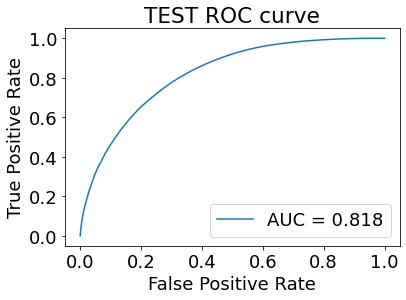

AUC: 0.818
Optimal threshold: 0.661
269550/269550 [==============================] - 71s 262us/sample - loss: 0.5199 - acc: 0.7509
{46, 47, 48, 49, 21, 22, 23, 24}
TEST
Mouse 4


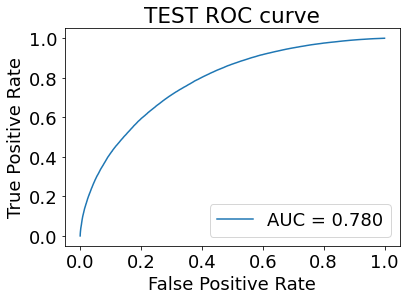

AUC: 0.780
Optimal threshold: 0.844
269550/269550 [==============================] - 71s 265us/sample - loss: 0.6885 - acc: 0.6821
{0, 1, 2, 3, 25, 26, 27, 28}
TEST
Mouse 4


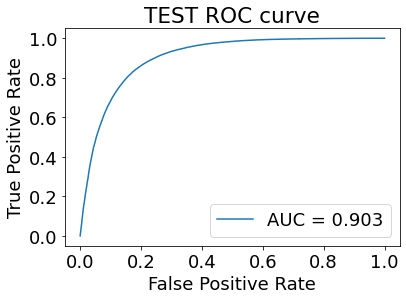

AUC: 0.903
Optimal threshold: 0.427
269550/269550 [==============================] - 74s 274us/sample - loss: 0.4068 - acc: 0.8285
{32, 33, 5, 6, 7, 8, 30, 31}
TEST
Mouse 4


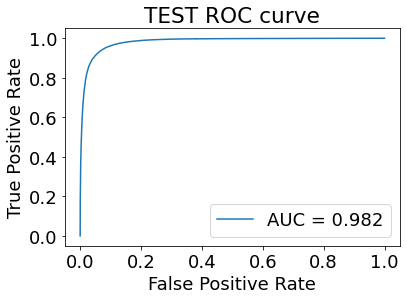

AUC: 0.982
Optimal threshold: 0.654
269550/269550 [==============================] - 72s 266us/sample - loss: 0.1718 - acc: 0.9361
{38, 39, 40, 41, 13, 14, 15, 16}
TEST
Mouse 4


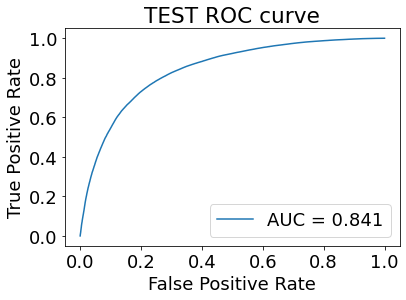

AUC: 0.841
Optimal threshold: 0.574
269550/269550 [==============================] - 73s 269us/sample - loss: 0.4866 - acc: 0.7731
{42, 43, 44, 45, 17, 18, 19, 20}
TEST
Mouse 4


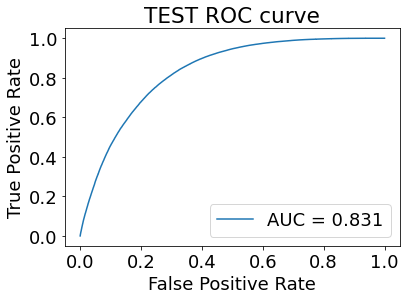

AUC: 0.831
Optimal threshold: 0.622
269550/269550 [==============================] - 74s 276us/sample - loss: 0.4945 - acc: 0.7735
{46, 47, 48, 49, 21, 22, 23, 24}
TEST
Mouse 4


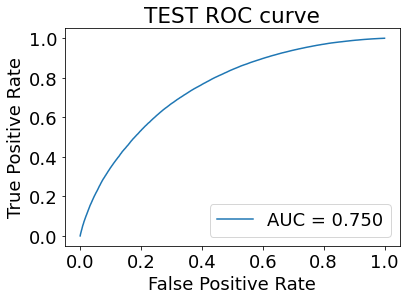

AUC: 0.750
Optimal threshold: 0.787
269550/269550 [==============================] - 75s 277us/sample - loss: 0.6687 - acc: 0.6835
{0, 1, 2, 3, 25, 26, 27, 28}
TEST
Mouse 4


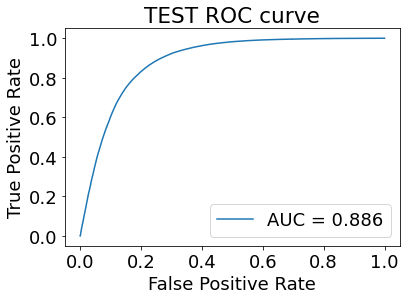

AUC: 0.886
Optimal threshold: 0.481
269550/269550 [==============================] - 71s 264us/sample - loss: 0.4111 - acc: 0.8245
{32, 33, 5, 6, 7, 8, 30, 31}
TEST
Mouse 4


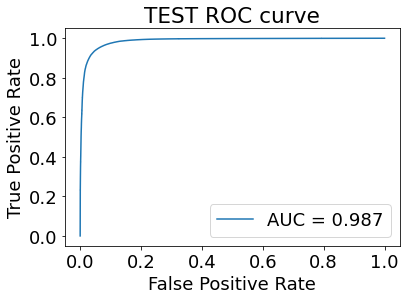

AUC: 0.987
Optimal threshold: 0.749
269550/269550 [==============================] - 75s 277us/sample - loss: 0.1490 - acc: 0.9441
{38, 39, 40, 41, 13, 14, 15, 16}
TEST
Mouse 4


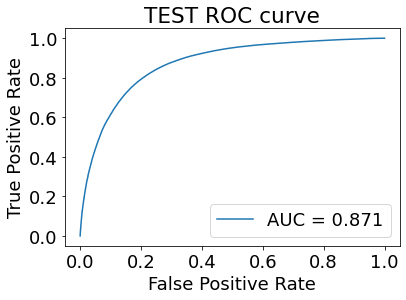

AUC: 0.871
Optimal threshold: 0.733
269550/269550 [==============================] - 72s 269us/sample - loss: 0.4852 - acc: 0.7997
{42, 43, 44, 45, 17, 18, 19, 20}
TEST
Mouse 4


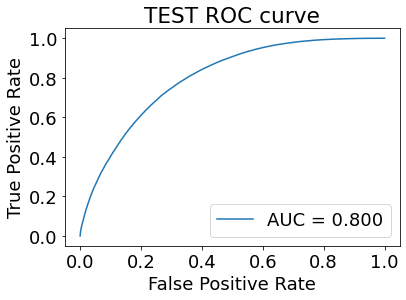

AUC: 0.800
Optimal threshold: 0.686
269550/269550 [==============================] - 73s 269us/sample - loss: 0.5614 - acc: 0.7390
{46, 47, 48, 49, 21, 22, 23, 24}
TEST
Mouse 4


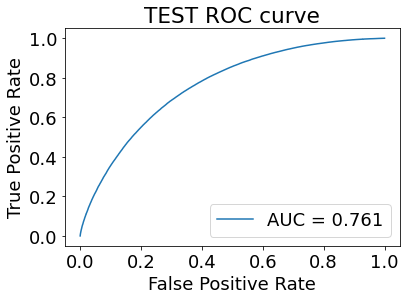

AUC: 0.761
Optimal threshold: 0.737
269550/269550 [==============================] - 70s 259us/sample - loss: 0.6369 - acc: 0.7054
{0, 1, 2, 3, 25, 26, 27, 28}
TEST
Mouse 5


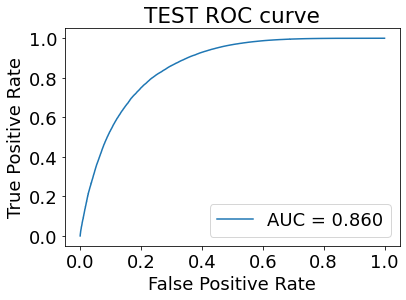

AUC: 0.860
Optimal threshold: 0.811
215640/215640 [==============================] - 59s 274us/sample - loss: 0.3235 - acc: 0.8756
{32, 33, 5, 6, 7, 8, 30, 31}
TEST
Mouse 5


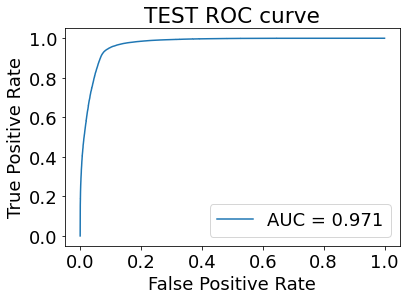

AUC: 0.971
Optimal threshold: 0.863
215640/215640 [==============================] - 59s 275us/sample - loss: 0.1488 - acc: 0.9506
{38, 39, 40, 41, 13, 14, 15, 16}
TEST
Mouse 5


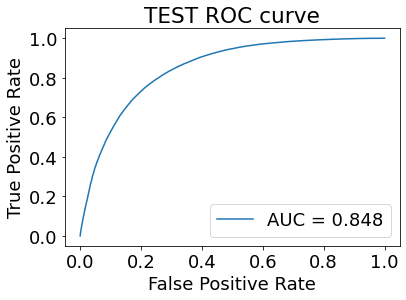

AUC: 0.848
Optimal threshold: 0.709
215640/215640 [==============================] - 61s 282us/sample - loss: 0.3672 - acc: 0.8496
{42, 43, 44, 45, 17, 18, 19, 20}
TEST
Mouse 5


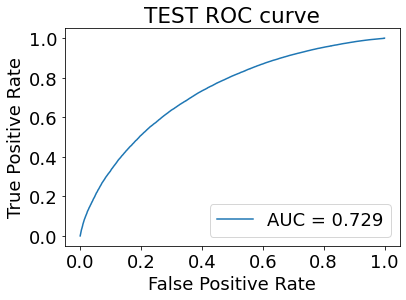

AUC: 0.729
Optimal threshold: 0.777
215640/215640 [==============================] - 60s 280us/sample - loss: 0.4733 - acc: 0.7903
{46, 47, 48, 49, 21, 22, 23, 24}
TEST
Mouse 5


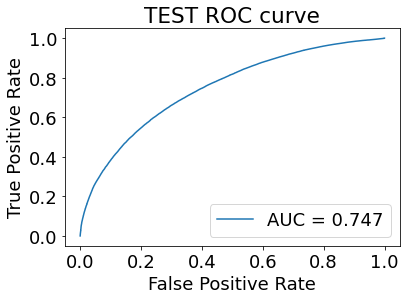

AUC: 0.747
Optimal threshold: 0.739
215640/215640 [==============================] - 58s 271us/sample - loss: 0.4956 - acc: 0.7721
{0, 1, 2, 3, 25, 26, 27, 28}
TEST
Mouse 5


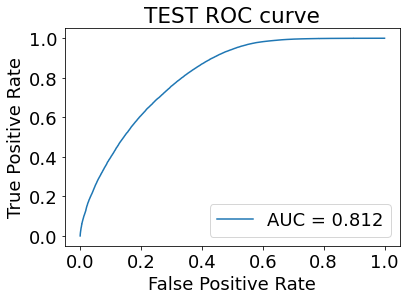

AUC: 0.812
Optimal threshold: 0.855
215640/215640 [==============================] - 60s 280us/sample - loss: 0.3793 - acc: 0.8656
{32, 33, 5, 6, 7, 8, 30, 31}
TEST
Mouse 5


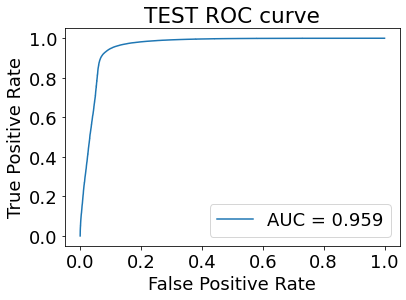

AUC: 0.959
Optimal threshold: 0.855
215640/215640 [==============================] - 62s 289us/sample - loss: 0.1643 - acc: 0.9479
{38, 39, 40, 41, 13, 14, 15, 16}
TEST
Mouse 5


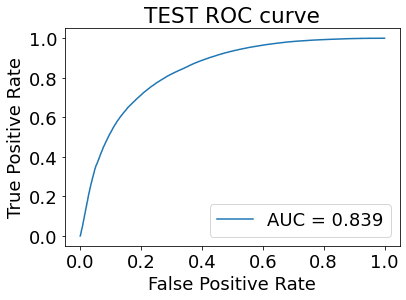

AUC: 0.839
Optimal threshold: 0.769
215640/215640 [==============================] - 60s 276us/sample - loss: 0.3677 - acc: 0.8478
{42, 43, 44, 45, 17, 18, 19, 20}
TEST
Mouse 5


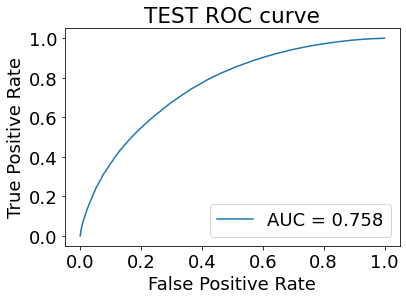

AUC: 0.758
Optimal threshold: 0.803
215640/215640 [==============================] - 62s 285us/sample - loss: 0.4388 - acc: 0.8160
{46, 47, 48, 49, 21, 22, 23, 24}
TEST
Mouse 5


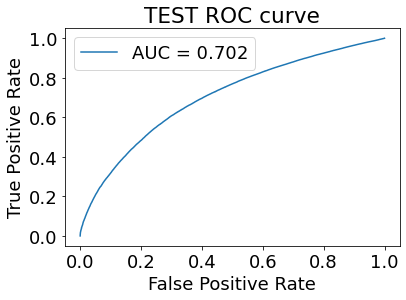

AUC: 0.702
Optimal threshold: 0.775
215640/215640 [==============================] - 61s 285us/sample - loss: 0.5054 - acc: 0.7638
{0, 1, 2, 3, 25, 26, 27, 28}
TEST
Mouse 5


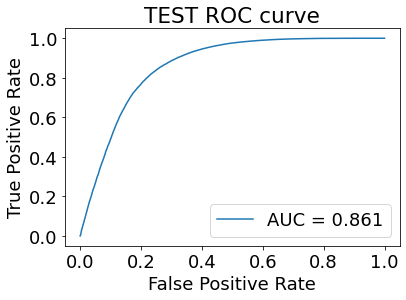

AUC: 0.861
Optimal threshold: 0.844
215640/215640 [==============================] - 62s 286us/sample - loss: 0.3230 - acc: 0.8771
{32, 33, 5, 6, 7, 8, 30, 31}
TEST
Mouse 5


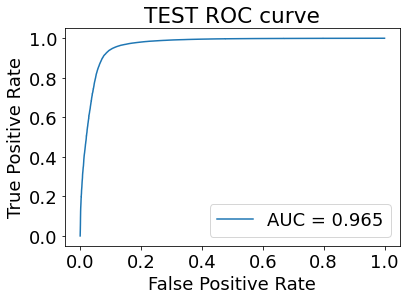

AUC: 0.965
Optimal threshold: 0.885
215640/215640 [==============================] - 59s 274us/sample - loss: 0.1702 - acc: 0.9447
{38, 39, 40, 41, 13, 14, 15, 16}
TEST
Mouse 5


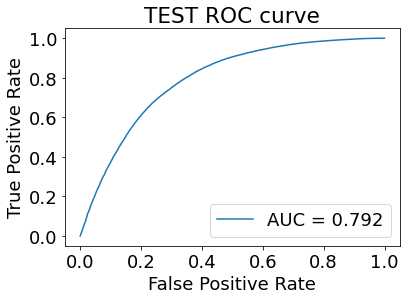

AUC: 0.792
Optimal threshold: 0.804
215640/215640 [==============================] - 62s 285us/sample - loss: 0.3948 - acc: 0.8379
{42, 43, 44, 45, 17, 18, 19, 20}
TEST
Mouse 5


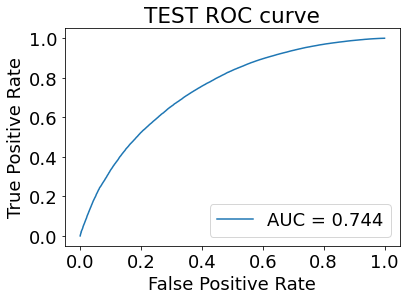

AUC: 0.744
Optimal threshold: 0.737
215640/215640 [==============================] - 59s 275us/sample - loss: 0.4694 - acc: 0.7949
{46, 47, 48, 49, 21, 22, 23, 24}
TEST
Mouse 5


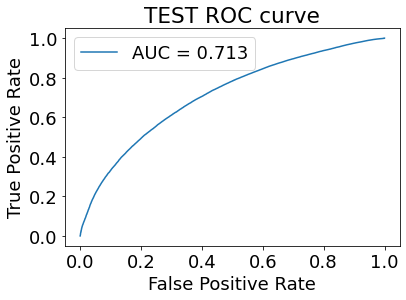

AUC: 0.713
Optimal threshold: 0.712
215640/215640 [==============================] - 63s 293us/sample - loss: 0.5344 - acc: 0.7481
{0, 1, 2, 3, 25, 26, 27, 28}
TEST
Mouse 5


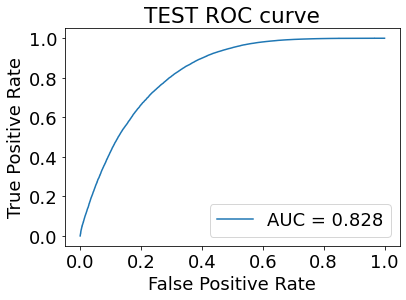

AUC: 0.828
Optimal threshold: 0.903
215640/215640 [==============================] - 62s 286us/sample - loss: 0.3962 - acc: 0.8650
{32, 33, 5, 6, 7, 8, 30, 31}
TEST
Mouse 5


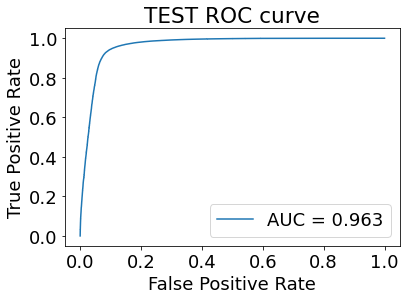

AUC: 0.963
Optimal threshold: 0.791
215640/215640 [==============================] - 60s 280us/sample - loss: 0.1619 - acc: 0.9461
{38, 39, 40, 41, 13, 14, 15, 16}
TEST
Mouse 5


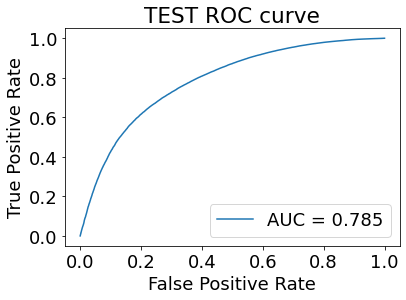

AUC: 0.785
Optimal threshold: 0.820
215640/215640 [==============================] - 61s 284us/sample - loss: 0.4350 - acc: 0.8142
{42, 43, 44, 45, 17, 18, 19, 20}
TEST
Mouse 5


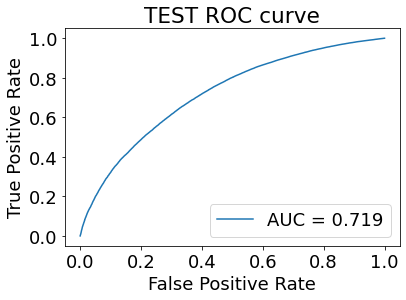

AUC: 0.719
Optimal threshold: 0.739
215640/215640 [==============================] - 62s 290us/sample - loss: 0.4947 - acc: 0.7783
{46, 47, 48, 49, 21, 22, 23, 24}
TEST
Mouse 5


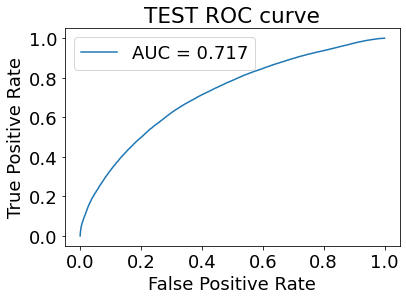

AUC: 0.717
Optimal threshold: 0.714
215640/215640 [==============================] - 61s 285us/sample - loss: 0.5507 - acc: 0.7412


In [17]:
df_AUC = pandas.DataFrame(numpy.zeros([20, 7]), columns=['VALID','TEST']+list(REGIONS.keys()))
df_LOSS = pandas.DataFrame(numpy.zeros([20, 7]), columns=['VALID','TEST']+list(REGIONS.keys()))
df_ACC = pandas.DataFrame(numpy.zeros([20, 7]), columns=['VALID','TEST']+list(REGIONS.keys()))

l = [1, 2, 3, 4, 5]
for raw, v in enumerate(itertools.permutations(l, 2)):
    TEST = [v[0]]
    VALID = [v[1]]
    df_AUC['TEST'][raw] = df_LOSS['TEST'][raw] = df_ACC['TEST'][raw] = v[0]
    df_AUC['VALID'][raw] = df_LOSS['VALID'][raw] = df_ACC['VALID'][raw] = v[1]
    for REGION in REGIONS:
        print(REGIONS[REGION])
        testX, testY = Get_Dataset(TEST, REGIONS[REGION])
        input_test = testX.transpose(0,2,1)
        for ModelType in Models:
            ver = f'{REGION}_{ModelType}_{VALID}_{TEST}'
            model_file_path = f'models_N20/{ModelType}/{REGION}/best_model_{ver}.h5'
            model = load_model(model_file_path)
            test_pred = model.predict(input_test)
            df_AUC[REGION][raw] = plot_roc(test_pred, testY, "TEST")
            results = model.evaluate(input_test,testY)
            df_LOSS[REGION][raw] = results[0]
            df_ACC[REGION][raw] = results[1]

In [18]:
df_AUC.to_csv('N20_8_region_result_AUC.csv')
df_AUC

,VALID,TEST,Motor,SomatosensoryLimb,P-RS,V1-MV,LV-SA
0,2.0,1.0,0.907571,0.885717,0.765664,0.863657,0.853662
1,3.0,1.0,0.910786,0.914215,0.522016,0.834689,0.818559
2,4.0,1.0,0.903965,0.914352,0.708374,0.881564,0.880833
3,5.0,1.0,0.912420,0.934193,0.829440,0.879018,0.868579
4,1.0,2.0,0.886675,0.983652,0.847954,0.776980,0.841298
5,3.0,2.0,0.884519,0.983913,0.588988,0.706758,0.743600
6,4.0,2.0,0.862522,0.983949,0.775071,0.781573,0.836835
7,5.0,2.0,0.870960,0.982169,0.859607,0.789652,0.840377
8,1.0,3.0,0.816252,0.985439,0.722064,0.782446,0.846656
9,2.0,3.0,0.815326,0.984007,0.670716,0.663829,0.748778


In [19]:
df_LOSS.to_csv('N20_8_region_result_BCEloss.csv')
df_LOSS

,VALID,TEST,Motor,SomatosensoryLimb,P-RS,V1-MV,LV-SA
0,2.0,1.0,0.412165,0.439263,0.632247,0.479076,0.576313
1,3.0,1.0,0.376940,0.418224,1.057679,0.494265,0.581049
2,4.0,1.0,0.376646,0.427767,0.766258,0.421856,0.436462
3,5.0,1.0,0.382928,0.360591,0.542911,0.461604,0.467164
4,1.0,2.0,0.759844,0.158020,0.515133,0.565644,0.515365
5,3.0,2.0,0.696887,0.151928,0.699418,0.673679,0.568839
6,4.0,2.0,0.952332,0.151375,0.563522,0.565272,0.526101
7,5.0,2.0,0.865484,0.153758,0.449480,0.579472,0.540308
8,1.0,3.0,0.572482,0.137910,0.789275,0.619057,0.582478
9,2.0,3.0,0.700539,0.147230,0.933564,0.645605,0.593697


In [20]:
df_ACC.to_csv('N20_8_region_result_Accuracy.csv')
df_ACC

,VALID,TEST,Motor,SomatosensoryLimb,P-RS,V1-MV,LV-SA
0,2.0,1.0,0.829048,0.811367,0.695670,0.778211,0.725472
1,3.0,1.0,0.830369,0.822957,0.410234,0.777301,0.709308
2,4.0,1.0,0.828472,0.823398,0.600081,0.802180,0.803602
3,5.0,1.0,0.835893,0.848753,0.750847,0.787596,0.779663
4,1.0,2.0,0.689292,0.940781,0.792919,0.736733,0.756172
5,3.0,2.0,0.695831,0.944644,0.610504,0.675417,0.710434
6,4.0,2.0,0.672273,0.942821,0.746341,0.749819,0.761867
7,5.0,2.0,0.665429,0.943012,0.808686,0.747324,0.762317
8,1.0,3.0,0.729525,0.951280,0.655457,0.710915,0.729541
9,2.0,3.0,0.712135,0.947031,0.599646,0.662048,0.713316
